In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error

In [2]:
data = pd.read_csv('MSFT.csv')
closing_prices = data['Close'].values.reshape(-1, 1)
scaler = MinMaxScaler()
closing_prices_scaled = scaler.fit_transform(closing_prices)

train_size = int(len(closing_prices_scaled) * 0.8)
train_data = closing_prices_scaled[:train_size]
test_data = closing_prices_scaled[train_size:]

In [3]:
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

In [4]:
seq_length = 10
X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)


In [5]:
X_train_rf_svm = X_train.reshape(-1, seq_length)
X_test_rf_svm = X_test.reshape(-1, seq_length)
y_train_rf_svm = y_train.flatten()
y_test_rf_svm = y_test.flatten()


In [6]:
svm_model = SVR(kernel='rbf')
svm_model.fit(X_train_rf_svm, y_train_rf_svm)

SVR()

In [7]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_rf_svm, y_train_rf_svm)

RandomForestRegressor(random_state=42)

In [20]:
lstm_model = Sequential()
lstm_model.add(LSTM(50, activation='relu', input_shape=(seq_length, 1)))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mean_squared_error')
lstm_model.fit(X_train, y_train, epochs=100, batch_size=4, verbose=1)


Epoch 1/100
304/304 [==============================] - 4s 6ms/step - loss: 0.0135
Epoch 2/100
304/304 [==============================] - 2s 6ms/step - loss: 3.8459e-04
Epoch 3/100
304/304 [==============================] - 2s 7ms/step - loss: 3.8172e-04
Epoch 4/100
304/304 [==============================] - 3s 8ms/step - loss: 3.5934e-04
Epoch 5/100
304/304 [==============================] - 2s 6ms/step - loss: 3.6651e-04
Epoch 6/100
304/304 [==============================] - 2s 6ms/step - loss: 3.4866e-04
Epoch 7/100
304/304 [==============================] - 2s 6ms/step - loss: 3.2736e-04
Epoch 8/100
304/304 [==============================] - 2s 6ms/step - loss: 3.0015e-04
Epoch 9/100
304/304 [==============================] - 2s 7ms/step - loss: 3.3169e-04
Epoch 10/100
304/304 [==============================] - 3s 10ms/step - loss: 3.1703e-04
Epoch 11/100
304/304 [==============================] - 2s 6ms/step - loss: 2.6357e-04
Epoch 12/100
304/304 [==============================] -

In [21]:
y_pred_svm = svm_model.predict(X_test_rf_svm)
y_pred_rf = rf_model.predict(X_test_rf_svm)
y_pred_lstm = lstm_model.predict(X_test)

10/10 [==============================] - 0s 3ms/step


In [22]:
y_pred_svm = scaler.inverse_transform(y_pred_svm.reshape(-1, 1))
y_pred_rf = scaler.inverse_transform(y_pred_rf.reshape(-1, 1))
y_pred_lstm = scaler.inverse_transform(y_pred_lstm)

In [23]:
y_test_orig = scaler.inverse_transform(y_test.reshape(-1, 1))

In [24]:
rmse_svm = np.sqrt(mean_squared_error(y_test_orig, y_pred_svm))
rmse_rf = np.sqrt(mean_squared_error(y_test_orig, y_pred_rf))
rmse_lstm = np.sqrt(mean_squared_error(y_test_orig, y_pred_lstm))


In [25]:
print(f"RMSE for SVM: {rmse_svm}")
print(f"RMSE for Random Forest: {rmse_rf}")
print(f"RMSE for LSTM: {rmse_lstm}")

RMSE for SVM: 15.939241445135954
RMSE for Random Forest: 6.628776111111253
RMSE for LSTM: 5.6900012654988


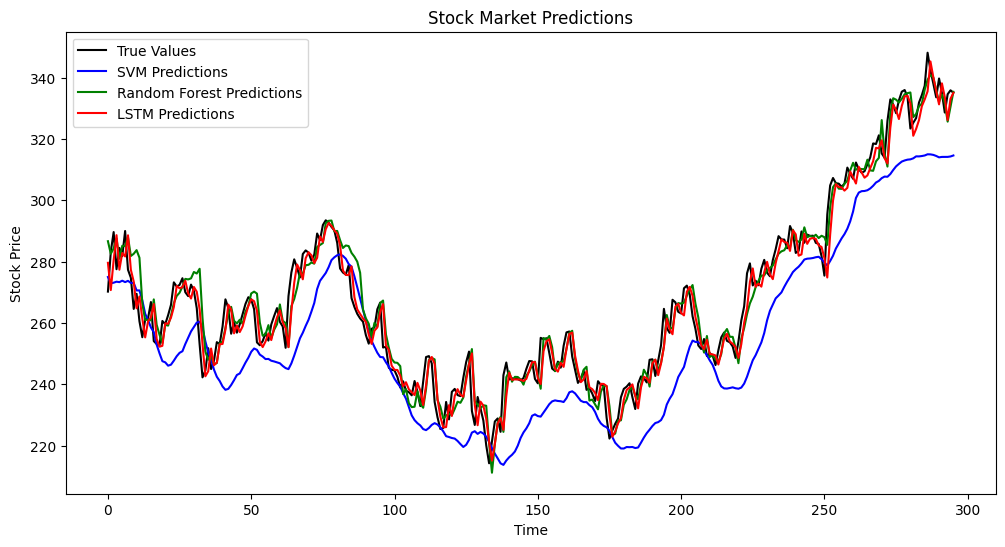

In [26]:
plt.figure(figsize=(12, 6))
plt.plot(y_test_orig, label='True Values', color='black')
plt.plot(y_pred_svm, label='SVM Predictions', color='blue')
plt.plot(y_pred_rf, label='Random Forest Predictions', color='green')
plt.plot(y_pred_lstm, label='LSTM Predictions', color='red')
plt.title('Stock Market Predictions')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [29]:
results_df = pd.DataFrame({
    'Actual': y_test_orig.flatten(),
    'SVM Predicted': y_pred_svm.flatten(),
    'Random Forest Predicted': y_pred_rf.flatten(),
    'LSTM Predicted': y_pred_lstm.flatten()
})
print(results_df)

         Actual  SVM Predicted  Random Forest Predicted  LSTM Predicted
0    270.220001     274.970839               286.654102      279.606659
1    283.220001     272.903840               282.550704      270.716187
2    289.630005     273.127818               284.280405      280.447083
3    277.519989     273.454014               287.535496      288.622681
4    284.470001     273.306936               280.915203      277.357941
..          ...            ...                      ...             ...
291  335.019989     314.130424               334.495199      338.125000
292  328.600006     314.141031               331.682701      333.656342
293  334.570007     314.140318               325.625601      326.170837
294  335.850006     314.277286               330.568498      333.104614
295  335.049988     314.600428               335.362100      335.026947

[296 rows x 4 columns]


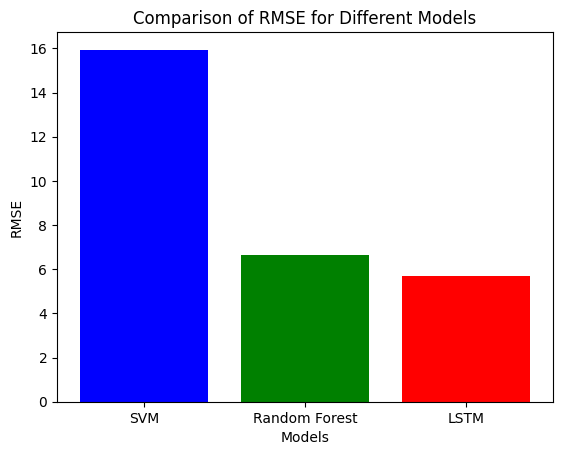

In [27]:
models = ['SVM', 'Random Forest', 'LSTM']
rmse_values = [rmse_svm, rmse_rf, rmse_lstm]

plt.bar(models, rmse_values, color=['blue', 'green', 'red'])
plt.xlabel('Models')
plt.ylabel('RMSE')
plt.title('Comparison of RMSE for Different Models')
plt.show()